In [30]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


#
from torch_geometric.utils import to_networkx
import networkx as nx

from src.rgcn_explainer_utils import *


In [7]:
name = 'aifb'
node_idx = 5905
#data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/finals/{name}.pt')
data = kg.load('aifb', torch=True) 
data = prunee(data, 2)
data.i2e[2949]
#110749%data.num_entities_new

from src.rgcn_explainer_utils import *
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}')
h = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_hor{node_idx}')
model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

out = model.forward2(h,v)
#print(out)
#res = nn.Softmax(dim=0)(model.forward2(h,v)[5757, :])
# da.training = torch.tensor(da.training, dtype=torch.int32)
# da.withheld = torch.tensor(da.withheld, dtype=torch.int32)
# idxw, clsw = da.withheld[:, 0], da.withheld[:, 1]
# out_val = out[idxw,:]
res = nn.Softmax(dim=0)(out[node_idx])
print('ypred explain', res)
print(v)
if node_idx in data.withheld[:,0]:
    print('ypred true', data.withheld[data.withheld[:,0]==node_idx,1])


loaded data aifb (0.1866s).
ypred explain tensor([0.2702, 0.3319, 0.2209, 0.1769], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[ 24263,  88755, 196460, 229600, 237885, 254455, 329020],
                       [  5905,     27,   2259,     28,   5670,   7693,   5230]]),
       values=tensor([0.1635, 0.1397, 0.9866, 0.9914, 0.1680, 0.3616, 0.9963]),
       size=(753935, 8285), nnz=7, layout=torch.sparse_coo)
ypred true tensor([1], dtype=torch.int32)


In [90]:
data.withheld

array([[3599,    3],
       [3594,    1],
       [3571,    2],
       [3595,    3],
       [3592,    3],
       [3602,    3],
       [3586,    3],
       [3587,    3],
       [3591,    3],
       [3585,    3],
       [3562,    0],
       [3577,    0],
       [3580,    2],
       [3590,    3],
       [3600,    3],
       [3601,    3],
       [3596,    1],
       [3603,    1],
       [3566,    0],
       [3597,    1],
       [3602,    4],
       [3581,    2],
       [3598,    3],
       [3603,    5]], dtype=int32)

In [5]:
d.__dict__.keys()

dict_keys(['name', 'triples', 'i2r', 'r2i', 'i2e', 'e2i', 'num_entities', 'num_relations', 'num_classes', 'training', 'withheld', '_dt_l2g', '_dt_g2l', '_datatypes', 'torch', 'final', 'training_people', 'withheld_people', 'training_withheld_people'])

In [13]:
data = kg.load('aifb', torch=True, final = False) 
print(f'Number of entities: {data.num_entities}') #data.i2e
print(f'Number of classes: {data.num_classes}')
print(f'Types of relations: {data.num_relations}') #data.i2r
name = 'aifb'
#get_relations(data)
#d_classes(data)
d = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
#model = torch.load(f'{name}_chk/model_{name}_prune_{prune}')
d

loaded data aifb (3.478s).
Number of entities: 8285
Number of classes: 4
Types of relations: 45


{0: [5678,
  5724,
  5699,
  5688,
  5702,
  5714,
  5708,
  5843,
  5873,
  5697,
  5783,
  5701,
  5845,
  5778],
 1: [5731, 5905, 5808, 5785],
 2: [5757, 5797, 5900, 5677, 5791, 5811, 5831, 5839, 5755, 5844, 5861],
 3: [5857, 5752, 5795, 5753, 5798, 5854]}

In [10]:
def match_to_triples(tensor1, tensor2):
    """
    tensor1: sub_edge tensor: edges of the neighborhood - transpose!!
    tensor2: data.triples: all edges
    """
    matching = []
    for i,i2 in zip(tensor1[:,0],tensor1[:,1]):
        for j,j1,j2, index in zip(tensor2[:,0],tensor2[:,1],  tensor2[:,2], range(len(tensor2[:,0]))):
            if i == j and i2 == j2:
                matching.append(tensor2[index])
                

    result = torch.stack(matching)
    return result

v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5757')
v.coalesce().indices()%data.num_entities
sel_masked_ver = sub_sparse_tensor(v, threshold=0.5,data=data, low_threshold=False)
indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) 
#v.coalesce().indices()//data.num_entities
match_to_triples(np.array(new_index), data.triples)

tensor([[5757,   23, 2227],
        [6860,    2, 5757],
        [6874,    2, 5757],
        [6920,    2, 5757],
        [7731,    2, 5757]])

In [42]:
v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5731')
v

tensor(indices=tensor([[ 23412,  23422,  23466,  23931,  24007,  24036,  24126,
                         24444,  24449,  24451,  24472,  63450,  88581, 115261,
                        130006, 146769, 147687, 147697, 147741, 148311, 148311,
                        148311, 148311, 148311, 148401, 148719, 148724, 148726,
                        148726, 148747, 154542, 154550, 154551, 154552, 154553,
                        154559, 154567, 154581, 154585, 154587, 154594, 179909,
                        179976, 196286, 229426, 237711, 246256, 254281, 254281,
                        254281, 254281, 254281, 254281, 254281, 254281, 254281,
                        254281, 254281, 303991, 303991, 328846],
                       [  5731,   5731,   5731,   5731,   5731,   5731,   5731,
                          5731,   5731,   5731,   5731,   5924,      0,   5991,
                          5184,   5455,   5451,   5451,   5451,   5412,   5423,
                          5437,   5451,   5457,   5451,

In [8]:
torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor')

tensor([[ 2, 10, 23, 27, 28, 30, 39],
        [ 0,  0,  0,  0,  0,  0,  0]])

In [38]:
def match_to_triples(v, data, sparse=True):
    if sparse:
        p,_ = torch.div(v.coalesce().indices(), data.num_entities, rounding_mode='floor') #v.coalesce().indices()//data.num_entities
        s,o = v.coalesce().indices()%data.num_entities
        result = torch.stack([s,p,o], dim=1)

    else:
        data = data.triples
        matching = []
        for i,i2 in zip(v[:,0],v[:,1]):
            for j,j1,j2, index in zip(data[:,0],data[:,1],  data[:,2], range(len(data[:,0]))):
                if i == j and i2 == j2:
                    matching.append(data[index])
                    

        result = torch.stack(matching)
    
    return result
match_to_triples(new_index.transpose(), data=data, sparse=False)

tensor([[5757,   30, 6860]])

In [15]:
a = np.array([[6860, 6874, 6920, 7731, 7933, 5757],
                       [5757, 5757, 5757, 5757, 5757, 7837]])
match_to_triples(a.transpose(), data=data, sparse=False)

tensor([[6860,    2, 5757],
        [6874,    2, 5757],
        [6920,    2, 5757],
        [7731,    2, 5757],
        [7933,    2, 5757],
        [5757,   30, 7837]])

In [25]:
node_idx = 5757
v = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/masked_adj/masked_ver{node_idx}')

match_to_triples(v, data=data, sparse=True)

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_1032/3767183713.py:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  p,_ = v.coalesce().indices()//data.num_entities


tensor([[6860,    2, 5757],
        [6874,    2, 5757],
        [6920,    2, 5757],
        [6976,    2, 5757],
        [7731,    2, 5757],
        [7837,    2, 5757],
        [7857,    2, 5757],
        [7905,    2, 5757],
        [7933,    2, 5757],
        [7973,    2, 5757],
        [5757,   10,  908],
        [5757,   23, 2227],
        [5757,   27, 1002],
        [5757,   30, 6860],
        [5757,   30, 6874],
        [5757,   30, 6920],
        [5757,   30, 6976],
        [5757,   30, 7731],
        [5757,   30, 7837],
        [5757,   30, 7857],
        [5757,   30, 7905],
        [5757,   30, 7933],
        [5757,   30, 7973],
        [5757,   39, 5230]])

In [34]:
def selected(masked_ver, threshold,data, low_threshold):
    sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) 
    triples_matched = match_to_triples(np.array(new_index), data)
    #triples_matched = match_to_triples(sel_masked_ver, data)
    #print(triples_matched)
    l = []
    for i in triples_matched[:,1]:
        l.append(data.i2rel[int(i)][0])

    return Counter(l)

selected(v, threshold=0.5,data=data, low_threshold=False)

Counter({'name': 1, 'author': 4})

In [43]:
def selected_float(masked_ver, threshold,data, low_threshold):
    ''' 
    masked_ver: masked adjacency matrix
    threshold: threshold for the masked adjacency matrix
    data: dataset
    low_threshold: if True, the threshold is applied to the masked adjacency matrix, otherwise to the original adjacency matrix
    returns: a dictionary with the sum of the mask for each relation'''
    sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
    sel_masked_ver = masked_ver
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) 
    triples_matched = match_to_triples(np.array(new_index), data)

    l = {}
    for i,j in zip(triples_matched[:,1],sel_masked_ver.coalesce().values()):

        if data.i2rel[int(i)][0] in l.keys():
            l[data.i2rel[int(i)][0]] += j
        else:
            l[data.i2rel[int(i)][0]] = j
   

    return Counter(l)
selected(v, threshold=0.5,data=data, low_threshold=False)

{'author': tensor(5.2977), 'fax': tensor(0.2127), 'name': tensor(0.9915), 'phone': tensor(0.1836), 'publication': tensor(0.2811), 'type': tensor(0.4484)}


Counter({'author': tensor(5.2977),
         'fax': tensor(0.2127),
         'name': tensor(0.9915),
         'phone': tensor(0.1836),
         'publication': tensor(0.2811),
         'type': tensor(0.4484)})

In [42]:
data.withheld
labels = {int(k):int(v) for k,v in zip(data.withheld[:, 0], data.withheld[:, 1])}
#sub_label = [labels[i] for i in [0,4276, 4171, 4214, 4172, 4217, 4273] if i != 0]
labels[5678]

0

In [41]:
i = [[0, 1, 1],[2,0,2]]
v =  [[3, 4], [5, 6], [7, 8]]
s = torch.sparse_coo_tensor(i, v, (2, 3, 2))
type(s.coalesce())

torch.Tensor

In [73]:
da = kg.load('aifb', torch=True) 
da = prunee(da)
print(f'Number of entities: {da.num_entities}') #data.i2e
print(f'Number of classes: {da.num_classes}')
print(f'Types of relations: {da.num_relations}') #data.i2r
name = 'aifb'
# get_relations(data)
# d_classes(data)
d = {key.item(): da.withheld[:, 0][da.withheld[:, 1] == key].tolist() for key in torch.unique(da.withheld[:, 1])}
#model = torch.load(f'{name}_chk/model_{name}_prune_{prune}')
d

loaded data aifb (0.2485s).
Number of entities: 8285
Number of classes: 4
Types of relations: 45


{0: [5678,
  5724,
  5699,
  5688,
  5702,
  5714,
  5708,
  5843,
  5873,
  5697,
  5783,
  5701,
  5845,
  5778],
 1: [5731, 5905, 5808, 5785],
 2: [5757, 5797, 5900, 5677, 5791, 5811, 5831, 5839, 5755, 5844, 5861],
 3: [5857, 5752, 5795, 5753, 5798, 5854]}

In [69]:
from src.rgcn_explainer_utils import *
v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5905')
h = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_hor5905')
model = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/model_aifb_prune_True')
out = model.forward2(h,v)
#print(out)
#res = nn.Softmax(dim=0)(model.forward2(h,v)[5757, :])
# da.training = torch.tensor(da.training, dtype=torch.int32)
# da.withheld = torch.tensor(da.withheld, dtype=torch.int32)
# idxw, clsw = da.withheld[:, 0], da.withheld[:, 1]
# out_val = out[idxw,:]
res = nn.Softmax(dim=0)(out[5905])
print('ypred explain', res)
print(v)
# visualize(node_idx=5757, n_hop = 2, data = data,masked_ver = v, threshold=0.5, name='aifb')
# visualize()

ypred explain tensor([0.2702, 0.3319, 0.2209, 0.1769], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[ 24263,  88755, 196460, 229600, 237885, 254455, 329020],
                       [  5905,     27,   2259,     28,   5670,   7693,   5230]]),
       values=tensor([0.1635, 0.1397, 0.9866, 0.9914, 0.1680, 0.3616, 0.9963]),
       size=(753935, 8285), nnz=7, layout=torch.sparse_coo)


In [75]:
for target_label in range(len(d.keys())):
    for node_idx in d[target_label]:
        if node_idx not in data.withheld[:, 0]:
            print('node_idx', node_idx)



loaded data aifb (0.2487s).
['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'type', 'volume', 'worksAtProject', 'year', 'type', 'type', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
tensor(indices=tensor([[ 23412,  23422,  23466,  23931,  24007,  24036,  24126,
                         24444,  24449,  24451,  24472,  63450,  88581, 115261,
                        130006, 146769, 147687, 147697, 147741, 148311, 148311,
                        148311, 148311, 148311, 148401, 148719, 148724, 148726,
                        148726, 148747, 154542, 154550, 154551, 154552, 154553,
                        154559, 154567, 154581, 154585, 15

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


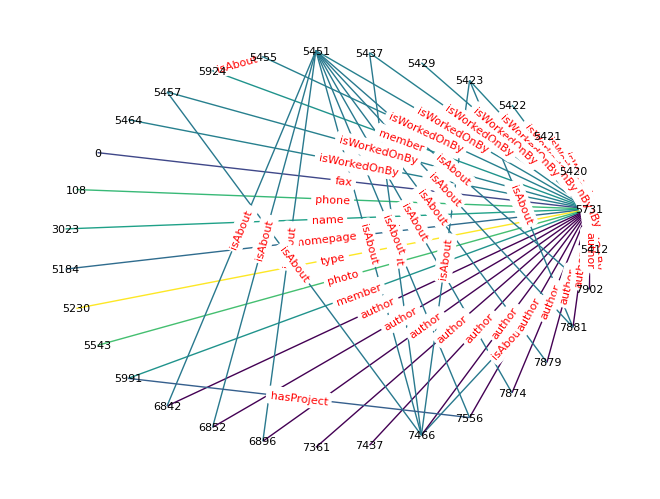

Counter({'isWorkedOnBy': 11,
         'isAbout': 15,
         'fax': 1,
         'phone': 1,
         'name': 1,
         'homepage': 1,
         'type': 1,
         'photo': 1,
         'member': 2,
         'author': 11,
         'hasProject': 1})

In [68]:
from src.rgcn_explainer_utils import *
data = kg.load('aifb', torch=True) 
#data = prunee(data)
data.entities = np.append(data.triples[:,0].detach().numpy(),(data.triples[:,2].detach().numpy()))
get_relations(data)
d_classes(data)
#breakpoint()

v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5731')
print(v)
visualize_(5731, 2, data, v, 0.5, 'aifb')

In [66]:
def sub_sparse_tensor_(sparse_tensor, threshold, data, low_threshold=False):
    if low_threshold:
        nonzero_indices = sparse_tensor.coalesce().indices()
        nonzero_indices[0] = nonzero_indices[0]%data.num_entities
        nonzero_values = sparse_tensor.coalesce().values()
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    else:
        nonzero_indices = sparse_tensor.coalesce().indices()
        nonzero_indices[0] = nonzero_indices[0]%data.num_entities
        nonzero_values = sparse_tensor.coalesce().values()
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)    
    return sel_masked_ver


def visualize_(node_idx, n_hop, data, masked_ver,threshold,name, result_weights=False, low_threshold=False ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    
    #select only nodes with a certain threshold
    sel_masked_ver = sub_sparse_tensor_(masked_ver, threshold,data, low_threshold)
    print('sel masked ver',sel_masked_ver)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:
        #get triples to get relations 
        triples_matched = match_to_triples(np.array(new_index), data.triples)
        l = []
        for i in triples_matched[:,1]:
            l.append(data.i2rel[int(i)][0])
        print(Counter(l))
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=int(p))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        # else:
        #     ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  

    print('dict index:', dict_index)

    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    color_list = list(encode_dict(dict_index).values())


    
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds,font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        # sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        # sm.set_array(weights)
        # cbar = plt.colorbar(sm)
        # cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
    else:
        rel = nx.get_edge_attributes(G,'weight')
        for k,v in rel.items():
            rel[k] = data.i2rel[v][0]
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights,node_color =  color_list, cmap="Set2",font_size=8)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=8,font_color='red')
        res = Counter(rel.values())
    if result_weights:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_weights.png')
        plt.show()
    else:
        if not os.path.exists(f'chk/{name}_chk/graphs'):
            os.makedirs(f'chk/{name}_chk/graphs')  
        plt.savefig(f'chk/{name}_chk/graphs/Explanation_{node_idx}_{n_hop}_relations.png')    
        plt.show()
        return res

In [11]:
v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5757')
h = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_hor5757')
model = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/model_aifb_prune_True')
res = nn.Softmax(dim=0)(model.forward2(h,v)[5757, :])
print('ypred explain', res)
print(v)
# a = nn.Softmax(dim=0)(model.forward2(h,v))[5757,:]
# a

ypred explain tensor([0.2610, 0.2667, 0.2997, 0.1726], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[ 23430,  23444,  23490,  23546,  24301,  24407,  24427,
                         24475,  24503,  24543,  88607, 196312, 229452, 254307,
                        254307, 254307, 254307, 254307, 254307, 254307, 254307,
                        254307, 254307, 328872],
                       [  5757,   5757,   5757,   5757,   5757,   5757,   5757,
                          5757,   5757,   5757,    908,   2227,   1002,   6860,
                          6874,   6920,   6976,   7731,   7837,   7857,   7905,
                          7933,   7973,   5230]]),
       values=tensor([0.9867, 0.9847, 0.9765, 0.1670, 0.9590, 0.1789, 0.2049,
                      0.1637, 0.4731, 0.2031, 0.2127, 0.9915, 0.1836, 0.0320,
                      0.0159, 0.0189, 0.0182, 0.0175, 0.0972, 0.0206, 0.0208,
                      0.0203, 0.0197, 0.4484]),
       size=(753935, 8285), nnz=24, layout=torch.sparse

In [15]:
v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_ver5678')
h = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/masked_adj/masked_hor5678')
model = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/aifb_chk/model_aifb_prune_True')
res = nn.Softmax(dim=0)(model.forward2(h,v)[5678, :])
print('ypred explain', res)
print(v)
a = nn.Softmax(dim=0)(model.forward2(h,v))[5678,:]
v_val = v.coalesce().values().detach().numpy()
v_val[v_val>0.5]

ypred explain tensor([0.4732, 0.1525, 0.2061, 0.1682], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[ 23451,  23458,  23551,  23567,  23615,  23638,  23670,
                         23963,  24431,  24481,  24538,  24580,  24582,  24583,
                         24584,  24585,  39077,  39079,  46927,  46927,  63352,
                         63403,  63408,  63426,  63445,  63489,  81452,  88528,
                        114586, 114592, 114593, 114702, 115616, 115715, 115717,
                        115718, 115719, 115720, 129953, 146782, 146782, 146784,
                        146784, 146784, 146784, 147726, 147732, 147826, 147842,
                        147890, 147913, 147945, 148238, 148238, 148756, 148855,
                        148857, 148858, 148859, 148860, 154487, 154538, 154543,
                        154561, 154580, 154624, 179487, 179922, 179924, 196233,
                        229373, 237658, 246202, 246204, 246204, 246204, 246204,
                        246204, 24620

array([0.9812773 , 0.96637964, 0.98790246], dtype=float32)

In [82]:
from r_exp import hor_ver_graph
model.eval()
hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[5724, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)

ypred full tensor([0.4840, 0.2345, 0.2195, 0.0620], grad_fn=<SoftmaxBackward0>)


In [49]:
from r_exp import hor_ver_graph

hor_graph, ver_graph = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
y_full = model.forward2(hor_graph, ver_graph)
node_pred_full = y_full[5757, :]
res_full = nn.Softmax(dim=0)(node_pred_full)
print('ypred full', res_full)
print(hor_graph)

ypred full tensor([0.0905, 0.1411, 0.7186, 0.0498], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[  4938,   4938,   4938,  ...,   7628,   7628,   8052],
                       [331296, 356145, 369832,  ..., 306895, 328335, 331293]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       size=(8285, 753935), nnz=29043, layout=torch.sparse_coo)


In [9]:

import torch
name = 'IMDb_us'
data = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/data/IMDB/{name}.pt')
data = prunee(data, 2)
model = torch.load(f'/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/{name}_chk/model_{name}_prune_True')

v = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/IMDb_us_chk/masked_adj/masked_ver5889')
h = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/IMDb_us_chk/masked_adj/masked_hor5889')
res = nn.Softmax(dim=0)(model.forward2(h,v)[5889, :])
print('ypred explain', res)
print(v)

ypred explain tensor([0.9018, 0.0982], grad_fn=<SoftmaxBackward0>)
tensor(indices=tensor([[  5889,  46887,  46887,  74219, 101551, 101551, 142549,
                        159625, 169881, 183547],
                       [  5317,   5773,  13607,   1205,   3150,   3648,   4522,
                          5889,    107,   1204]]),
       values=tensor([0.7596, 0.3711, 0.3756, 0.7508, 0.3110, 0.3572, 0.8795,
                      0.6714, 0.7697, 0.7539]),
       size=(2391550, 13666), nnz=10, layout=torch.sparse_coo)


In [86]:
a = 0
for i in da.triples:
    if 5731 in i:
        #print(i)
        a += 1
a   
da.i2e[5731]

('http://www.aifb.uni-karlsruhe.de/Personen/viewPersonOWL/id19instance', 'iri')

In [125]:
def prunee(data , n=2):
    """
    Prune a given dataset. That is, reduce the number of triples to an n-hop neighborhood around the labeled nodes. This
    can save a lot of memory if the model being used is known to look only to a certain depth in the graph.

    Note that switching between non-final and final mode will result in different pruned graphs.

    :param data:
    :return:
    """

    data_triples = data.triples
    data_training = data.training
    data_withheld = data.withheld

    if data.torch:
        data_triples = data_triples.numpy()
        data_training = data_training.numpy()
        data_withheld = data_withheld.numpy()

    assert n >= 1

    entities = set()

    for e in data_training[:, 0]:
        entities.add(e)
    for e in data_withheld[:, 0]:
        entities.add(e)

    entities_add = set()
    for _ in range(n):
        for s, p, o in data_triples:
            if s in entities:
                entities_add.add(o)
            if o in entities:
                entities_add.add(s)
        entities.update(entities_add)
    print(entities)
    # new index to old index
    n2o = list(entities)
    o2n = {o: n for n, o in enumerate(entities)}

    nw = Data(dir=None)

    nw.num_entities = len(n2o)
    nw.num_relations = data.num_relations
    nw.i2e = data.i2e
    nw.e2i = data.e2i
    #nw.i2e = [data.i2e[i] for i in range(len(n2o))] #[data.i2e[n2o[i]] for i in range(len(n2o))]
    #nw.e2i = {e: i for i, e in enumerate(nw.i2e)}

    # relations are unchanged, but copied for the sake of GC
    nw.i2r = list(data.i2r)
    nw.r2i = dict(data.r2i)

    # count the new number of triples
    num = 0
    for s, p, o in data_triples:
        if s in entities and o in entities:
            num += 1

    nw.triples = np.zeros((num, 3), dtype=int)

    row = 0
    for s, p, o in data_triples:
        if s in entities and o in entities:
            #s, o =  o2n[s], o2n[o]
            s,o = s,o
            nw.triples[row, :] = (s, p, o)
            row += 1

    nw.training = data_training.copy()
    for i in range(nw.training.shape[0]):
        nw.training[i, 0] = nw.training[i, 0] #o2n[nw.training[i, 0]]

    nw.withheld = data_withheld.copy()
    for i in range(nw.withheld.shape[0]):
        nw.withheld[i, 0] = nw.withheld[i, 0] #o2n[nw.withheld[i, 0]]

    nw.num_classes = data.num_classes

    nw.final = data.final
    nw.torch = data.torch
    if nw.torch:  # this should be constant-time/memory
        nw.triples = torch.from_numpy(nw.triples)
        nw.training = torch.from_numpy(nw.training)
        nw.withheld = torch.from_numpy(nw.withheld)

    return nw

In [126]:
da_pruned = prunei(da,2)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 44, 45, 46, 47, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 101, 105, 106, 107, 108, 109, 110, 113, 114, 116, 117, 118, 120, 121, 131, 133, 134, 135, 136, 137, 138, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 261, 262, 263, 264, 266, 267, 268, 269, 270, 271,

In [127]:
data = da_pruned
print(data.triples.shape)
data.entities = np.append(data.triples[:,0].detach().numpy(),(data.triples[:,2].detach().numpy()))
indices_nodes = data.entities
d = list(data.e2i.keys())
print(len(d), len(indices_nodes))
indices_nodes
values_indices_nodes = [d[i] for i in indices_nodes]

torch.Size([26666, 3])
8285 53332


In [117]:
data = da
print(data.triples.shape)
data.entities = np.append(data.triples[:,0].detach().numpy(),(data.triples[:,2].detach().numpy()))
indices_nodes = data.entities
d = list(data.e2i.keys())
indices_nodes
print(len(d), len(indices_nodes))
values_indices_nodes = [d[i] for i in indices_nodes]

torch.Size([29043, 3])
8285 58086


In [103]:
a = 0
for i in da_pruned.triples:
    if 5731 in i:
        print(i)
        a += 1
  


tensor([5412,   18, 5731])
tensor([5420,   18, 5731])
tensor([5421,   18, 5731])
tensor([5422,   18, 5731])
tensor([5423,   18, 5731])
tensor([5429,   18, 5731])
tensor([5437,   18, 5731])
tensor([5451,   18, 5731])
tensor([5455,   18, 5731])
tensor([5457,   18, 5731])
tensor([5464,   18, 5731])
tensor([5731,   10,    0])
tensor([5731,   15, 5184])
tensor([5731,   23, 3023])
tensor([5731,   27,  108])
tensor([5731,   28, 5543])
tensor([5731,   30, 6842])
tensor([5731,   30, 6852])
tensor([5731,   30, 6896])
tensor([5731,   30, 7361])
tensor([5731,   30, 7437])
tensor([5731,   30, 7466])
tensor([5731,   30, 7556])
tensor([5731,   30, 7874])
tensor([5731,   30, 7879])
tensor([5731,   30, 7881])
tensor([5731,   30, 7902])
tensor([5731,   36, 5924])
tensor([5731,   36, 5991])
tensor([5731,   39, 5230])
tensor([5924,   21, 5731])
tensor([5991,   21, 5731])
tensor([6842,    2, 5731])
tensor([6852,    2, 5731])
tensor([6896,    2, 5731])
tensor([7361,    2, 5731])
tensor([7437,    2, 5731])
t

In [105]:
a = 0
for i in da.triples:
    if 5731 in i:
        print(i)
        a += 1

tensor([5412,   18, 5731])
tensor([5420,   18, 5731])
tensor([5421,   18, 5731])
tensor([5422,   18, 5731])
tensor([5423,   18, 5731])
tensor([5429,   18, 5731])
tensor([5437,   18, 5731])
tensor([5451,   18, 5731])
tensor([5455,   18, 5731])
tensor([5457,   18, 5731])
tensor([5464,   18, 5731])
tensor([5731,   10,    0])
tensor([5731,   15, 5184])
tensor([5731,   23, 3023])
tensor([5731,   27,  108])
tensor([5731,   28, 5543])
tensor([5731,   30, 6842])
tensor([5731,   30, 6852])
tensor([5731,   30, 6896])
tensor([5731,   30, 7361])
tensor([5731,   30, 7437])
tensor([5731,   30, 7466])
tensor([5731,   30, 7556])
tensor([5731,   30, 7874])
tensor([5731,   30, 7879])
tensor([5731,   30, 7881])
tensor([5731,   30, 7902])
tensor([5731,   36, 5924])
tensor([5731,   36, 5991])
tensor([5731,   39, 5230])
tensor([5924,   21, 5731])
tensor([5991,   21, 5731])
tensor([6842,    2, 5731])
tensor([6852,    2, 5731])
tensor([6896,    2, 5731])
tensor([7361,    2, 5731])
tensor([7437,    2, 5731])
t

In [131]:
from rgcn_explainer_utils import *
edge_index = edge_index_oneadj(data.triples)
edge_index
find_n_hop_neighbors(edge_index,2,5757)

([(4945, 5230),
  (4946, 5230),
  (4951, 5230),
  (4973, 5230),
  (4974, 5230),
  (4987, 5230),
  (4988, 5230),
  (4998, 5230),
  (4999, 5230),
  (5005, 5230),
  (5010, 5230),
  (5014, 5230),
  (5022, 5230),
  (5042, 5230),
  (5053, 5230),
  (5063, 5230),
  (5078, 5230),
  (5081, 5230),
  (5085, 5230),
  (5202, 8176),
  (5202, 5081),
  (5202, 5238),
  (5211, 8176),
  (5211, 5230),
  (5219, 8176),
  (5219, 4987),
  (5219, 4988),
  (5219, 5238),
  (5220, 8176),
  (5220, 4998),
  (5220, 4999),
  (5220, 5238),
  (5230, 8176),
  (5230, 5027),
  (5230, 5028),
  (5230, 5029),
  (5230, 5030),
  (5230, 5031),
  (5230, 5032),
  (5230, 5033),
  (5238, 8176),
  (5246, 8176),
  (5246, 5230),
  (5247, 8176),
  (5351, 5954),
  (5351, 5680),
  (5351, 5740),
  (5351, 5760),
  (5351, 5775),
  (5351, 5782),
  (5351, 5791),
  (5351, 5811),
  (5351, 5835),
  (5351, 5853),
  (5351, 5861),
  (5351, 5862),
  (5351, 5876),
  (5351, 5878),
  (5351, 5886),
  (5351, 5897),
  (5351, 5904),
  (5351, 5906),
  (5351,

In [2]:
imdb = torch.load("/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/RGCN_stuff/IMDb_typePeople_data.pt")

In [35]:
imdb.num_relations

228

In [9]:
imdb_pred = torch.load("pred_imdb_torch",map_location=torch.device('cpu'))
imdb_pred

tensor([27, 27, 29,  ..., 27, 27, 50])

In [140]:
from rgcn_explainer_utils import prunee
data = kg.load('aifb', torch=True) 
data = prunee(data,2)
print(f'Number of entities: {data.num_entities}') #data.i2e
print(f'Number of classes: {data.num_classes}')
print(f'Types of relations: {data.num_relations}') #data.i2r
get_relations(data)

d = {key.item(): data.withheld[:, 0][data.withheld[:, 1] == key].tolist() for key in torch.unique(data.withheld[:, 1])}
# for i in d[0]:
#     print(data.i2e[i])
d

ImportError: cannot import name 'prunee' from 'rgcn_explainer_utils' (/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/RGCN_stuff/rgcn_explainer_utils.py)

In [134]:

from rgcn_explainer_utils import *
def selected(masked_ver, threshold,data, low_threshold):
    sel_masked_ver = sub_sparse_ten(masked_ver, threshold,data, low_threshold)
    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) 
    triples_matched = match_to_triples(np.array(new_index), data.triples)
    #print(triples_matched)
    l = []
    for i in triples_matched[:,1]:
        l.append(data.i2rel[int(i)][0])

    return Counter(l)

masked_ver = torch.load("/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/aifb_chk/masked_adj/masked_ver5757")
threshold = 0.5
low_threshold = False
sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)
indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) 
new_index
s = selected(masked_ver, threshold,data, low_threshold)
# s

In [135]:
s

Counter({'fax': 1, 'phone': 1, 'name': 1, '1999': 1, 'author': 10})

In [66]:
for i in data.triples:
    if 908 in i:
        print(i)


tensor([6385,   26,  908])


In [46]:
triples_matched = match_to_triples(np.array(new_index), data.triples)
triples_matched

[]


In [57]:
def sub_sparse_ten(sparse_tensor, threshold, data, low_threshold=False):
    if low_threshold:
        nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() < threshold]
        nonzero_indices[0] = nonzero_indices[0]%8285
        nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() < threshold]
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    else:
        nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() > threshold]
        nonzero_indices[0] = nonzero_indices[0]%8285
        nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() > threshold]
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)    
    return sel_masked_ver

In [45]:
def match_to_triples(tensor1, tensor2):
    """
    tensor1: sub_edge tensor: edges of the neighborhood - transpose!!
    tensor2: data.triples: all edges
    """
    matching = []
    for i,i2 in zip(tensor1[:,0],tensor1[:,1]):
        for j,j1,j2, index in zip(tensor2[:,0],tensor2[:,1],  tensor2[:,2], range(len(tensor2[:,0]))):
            if i == j and i2 == j2:
                matching.append(tensor2[index])
                
    print(matching)
    # result = torch.stack(matching)
    # return result

# STEPS
1. edge index
2. Neighborhood
3. Extract neighborhood
4. Match to triples
5. Match to classes
6. Preprocess data: enrich, sum sparse, adj 
6. Get hor ver edges (adjacency for rels)
7. Edge mask
8. Masked hor ver edges
9. Train and save model and predictions
10. Loss function
11. Explain class - namely put all together
12. Forward and optimize for the masked adjacency


In [18]:
#edge index
def edge_index_oneadj(triples):
    edge_index = torch.stack((triples[:, 0], triples[:, 2]),dim=0)
    return edge_index

#Neighborhood
#Extract neighborhood

def find_n_hop_neighbors(edge_index, n, node=None):
    """ 
    edge_index 
    n = num hops
    node = node_idx
    """
    # create dictionary of node neighborhoods
    neighborhoods = {}
    for i in range(edge_index.max().item() + 1):
        neighborhoods[i] = set()

    # find 1-hop neighbors and corresponding edges
    edges = []
    for j in range(edge_index.shape[1]):
        src, dst = edge_index[0, j].item(), edge_index[1, j].item()
        neighborhoods[src].add(dst)
        neighborhoods[dst].add(src)
        edges.append((src, dst))

    # find n-hop neighbors for the specified node or all nodes

    for k in range(2, n+1):
        new_neighbors = set()
        for neighbor in neighborhoods[node]:
            new_neighbors.update(neighborhoods[neighbor])
        neighborhoods[node].update(new_neighbors)
    sub_edges = []
    for edge in edges:
        src, dst = edge
        if src in neighborhoods[node] and dst in neighborhoods[node] or src == node or dst == node:
            sub_edges.append(edge)
            
    sub_edges_tensor = torch.tensor([sub_edges[i] for i in range(len(sub_edges))]).t()        

    #return {node: sub_edges}, {node: neighborhoods[node]}, sub_edges_tensor
    return sub_edges, neighborhoods[node], sub_edges_tensor


#match triples 
def match_to_triples(tensor1, tensor2):
    """
    tensor1: sub_edge tensor: edges of the neighborhood - transpose!!
    tensor2: data.triples: all edges
    """
    matching = []
    for i,i2 in zip(tensor1[:,0],tensor1[:,1]):
        for j,j1,j2, index in zip(tensor2[:,0],tensor2[:,1],  tensor2[:,2], range(len(tensor2[:,0]))):
            if i == j and i2 == j2:
                matching.append(tensor2[index])

    result = torch.stack(matching)
    return result



#PREPROCESS
def enrich(triples : torch.Tensor, n : int, r: int):
    """
    Enriches the given triples with self-loops and inverse relations.

    """
    cuda = triples.is_cuda

    inverses = torch.cat([
        triples[:, 2:],
        triples[:, 1:2] + r,
        triples[:, :1]
    ], dim=1)

    selfloops = torch.cat([
        torch.arange(n, dtype=torch.long,  device=d(cuda))[:, None],
        torch.full((n, 1), fill_value=2*r),
        torch.arange(n, dtype=torch.long, device=d(cuda))[:, None],
    ], dim=1)

    return torch.cat([triples, inverses, selfloops], dim=0)

def sum_sparse(indices, values, size, row=True):
    """
    Sum the rows or columns of a sparse matrix, and redistribute the
    results back to the non-sparse row/column entries

    :return:
    """

    ST = torch.cuda.sparse.FloatTensor if indices.is_cuda else torch.sparse.FloatTensor

    assert len(indices.size()) == 2

    k, r = indices.size()

    if not row:
        # transpose the matrix
        indices = torch.cat([indices[:, 1:2], indices[:, 0:1]], dim=1)
        size = size[1], size[0]

    ones = torch.ones((size[1], 1), device=d(indices))

    smatrix = ST(indices.t(), values, size=size)
    sums = torch.mm(smatrix, ones) # row/column sums

    sums = sums[indices[:, 0]]

    assert sums.size() == (k, 1)

    return sums.view(k)

def adj(triples, num_nodes, num_rels, cuda=False, vertical=True):
    """
     Computes a sparse adjacency matrix for the given graph (the adjacency matrices of all
     relations are stacked vertically).

     :param edges: List representing the triples
     :param i2r: list of relations
     :param i2n: list of nodes
     :return: sparse tensor
    """
    r, n = num_rels, num_nodes
    size = (r * n, n) if vertical else (n, r * n)

    from_indices = []
    upto_indices = []

    for s, p, o in triples:

        offset = p.item() * n
        

        if vertical:
            s = offset + s.item()
        else:
            o = offset + o.item()

        from_indices.append(s)
        upto_indices.append(o)
        

    indices = torch.tensor([from_indices, upto_indices], dtype=torch.long, device=d(cuda))


    assert indices.size(1) == len(triples)
    assert indices[0, :].max() < size[0], f'{indices[0, :].max()}, {size}, {r}'
    assert indices[1, :].max() < size[1], f'{indices[1, :].max()}, {size}, {r}'

    return indices.t(), size






#Get adjacency matrix: in this context this is hor / ver graph
def hor_ver_graph(triples, n, r):
    #triples = enrich(triples_small, n, r)

    hor_ind, hor_size = adj(triples, n, 2*r+1, vertical=False)
    ver_ind, ver_size = adj(triples, n, 2*r+1, vertical=True)
    #number of relations is 2*r+1 because we added the inverse and self loop

    _, rn = hor_size #horizontally stacked adjacency matrix size
    print(hor_size)
    r = rn // n #number of relations enriched divided by number of nodes

    vals = torch.ones(ver_ind.size(0), dtype=torch.float) #number of enriched triples
    vals = vals / sum_sparse(ver_ind, vals, ver_size) #normalize the values by the number of edges

    hor_graph = torch.sparse.FloatTensor(indices=hor_ind.t(), values=vals, size=hor_size) #size: n,r, emb


    ver_graph = torch.sparse.FloatTensor(indices=ver_ind.t(), values=vals, size=ver_size)

    return hor_graph, ver_graph


#Edge mask

def construct_edge_mask( num_nodes, init_strategy="normal", const_val=1.0):
    """
    Construct edge mask
    input;
        num_nodes: number of nodes in the neighborhood
        init_strategy: initialization strategy for the mask
        const_val: constant value for the mask
    output:
        mask: edge mask    
    """
    mask = nn.Parameter(torch.FloatTensor(num_nodes))  #initialize the mask
    if init_strategy == "normal":
        std = nn.init.calculate_gain("relu") * math.sqrt(
            2.0 / (num_nodes + num_nodes)
        )
        with torch.no_grad():
            mask.normal_(1.0, std)
    elif init_strategy == "const":
        nn.init.constant_(mask, const_val)
    return torch.tensor(mask)

#Masked 'adjacency' - masked hor vergraph

def _masked_adj(mask,adj, diag_mask, graph):
    """ Masked adjacency matrix 
    input: edge_mask, sub_adj, diag_mask
    output: masked_adj
    """
    sym_mask = mask
    sym_mask = torch.sigmoid(mask)
    
    sym_mask = (sym_mask + sym_mask.t()) / 2
    adj = torch.tensor(adj)
    masked_adj = adj * sym_mask

    #return masked_adj #* diag_mask
    return torch.sparse.FloatTensor(indices=graph.coalesce().indices(), values= masked_adj, size=graph.coalesce().size())



#match tro classes
def match_to_classes(tensor1, tensor2):
    """
    tensor1: sub graph indices
    tensor2: data.y labelsss
    """
    matching = []
    for i in (tensor1[:,0]):
        for j, index in zip(tensor2[:,0],range(len(tensor2[:,0]))):
            if i == j:
                matching.append(tensor2[index])
    return matching

## RGCN MODEL

In [19]:
class RGCN(nn.Module):
    """
    Classic RGCN
    """

    def __init__(self, triples, n, r, numcls, emb=16, bases=None):

        super().__init__()

        self.emb = emb
        self.bases = bases
        self.numcls = numcls

        self.triples = enrich(triples, n, r)

        # horizontally and vertically stacked versions of the adjacency graph
        hor_ind, hor_size = adj(self.triples, n, 2*r+1, vertical=False)
        ver_ind, ver_size = adj(self.triples, n, 2*r+1, vertical=True)
        #number of relations is 2*r+1 because we added the inverse and self loop

        _, rn = hor_size #horizontally stacked adjacency matrix size
        r = rn // n #number of relations enriched divided by number of nodes

        vals = torch.ones(ver_ind.size(0), dtype=torch.float) #number of enriched triples
        vals = vals / sum_sparse(ver_ind, vals, ver_size) #normalize the values by the number of edges

        hor_graph = torch.sparse.FloatTensor(indices=hor_ind.t(), values=vals, size=hor_size) #size: n,r, emb
        
        
        self.register_buffer('hor_graph', hor_graph)

        ver_graph = torch.sparse.FloatTensor(indices=ver_ind.t(), values=vals, size=ver_size)
        self.register_buffer('ver_graph', ver_graph)

        # layer 1 weights
        if bases is None:
            self.weights1 = nn.Parameter(torch.FloatTensor(r, n, emb))
            nn.init.xavier_uniform_(self.weights1, gain=nn.init.calculate_gain('relu'))

            self.bases1 = None
        else:
            self.comps1 = nn.Parameter(torch.FloatTensor(r, bases))
            nn.init.xavier_uniform_(self.comps1, gain=nn.init.calculate_gain('relu'))

            self.bases1 = nn.Parameter(torch.FloatTensor(bases, n, emb))
            nn.init.xavier_uniform_(self.bases1, gain=nn.init.calculate_gain('relu'))

        # layer 2 weights
        if bases is None:

            self.weights2 = nn.Parameter(torch.FloatTensor(r, emb, numcls) )
            nn.init.xavier_uniform_(self.weights2, gain=nn.init.calculate_gain('relu'))

            self.bases2 = None
        else:
            self.comps2 = nn.Parameter(torch.FloatTensor(r, bases))
            nn.init.xavier_uniform_(self.comps2, gain=nn.init.calculate_gain('relu'))

            self.bases2 = nn.Parameter(torch.FloatTensor(bases, emb, numcls))
            nn.init.xavier_uniform_(self.bases2, gain=nn.init.calculate_gain('relu'))

        self.bias1 = nn.Parameter(torch.FloatTensor(emb).zero_())
        self.bias2 = nn.Parameter(torch.FloatTensor(numcls).zero_())

    def forward2(self, hor_graph, ver_graph):


        ## Layer 1

        n, rn = hor_graph.size() #horizontally stacked adjacency matrix size
        r = rn // n
        e = self.emb
        b, c = self.bases, self.numcls

        if self.bases1 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps1, self.bases1)
            weights = torch.mm(self.comps1, self.bases1.view(b, n*e)).view(r, n, e)
        else:
            weights = self.weights1

        assert weights.size() == (r, n, e) #r relations, n nodes, e embedding size

        # Apply weights and sum over relations
        #hidden layer
        h = torch.mm(hor_graph, weights.view(r*n, e))  #matmul with horizontally stacked adjacency matrix and initialized weights
        assert h.size() == (n, e)

        h = F.relu(h + self.bias1) #apply non linearity and add bias

        ## Layer 2

        # Multiply adjacencies by hidden
        h = torch.mm(ver_graph, h) # sparse mm
        h = h.view(r, n, e) # new dim for the relations

        if self.bases2 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps2, self.bases2)
            weights = torch.mm(self.comps2, self.bases2.view(b, e * c)).view(r, e, c)
        else:
            weights = self.weights2

        # Apply weights, sum over relations
        # h = torch.einsum('rhc, rnh -> nc', weights, h)
        h = torch.bmm(h, weights).sum(dim=0)

        assert h.size() == (n, c)

        return h + self.bias2 # -- softmax is applied in the loss
    



    def forward(self):


        ## Layer 1

        n, rn = self.hor_graph.size() #horizontally stacked adjacency matrix size
        r = rn // n
        e = self.emb
        b, c = self.bases, self.numcls

        if self.bases1 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps1, self.bases1)
            weights = torch.mm(self.comps1, self.bases1.view(b, n*e)).view(r, n, e)
        else:
            weights = self.weights1

        assert weights.size() == (r, n, e) #r relations, n nodes, e embedding size

        # Apply weights and sum over relations
        #hidden layer
        h = torch.mm(self.hor_graph, weights.view(r*n, e))  #matmul with horizontally stacked adjacency matrix and initialized weights
        assert h.size() == (n, e)

        h = F.relu(h + self.bias1) #apply non linearity and add bias

        ## Layer 2

        # Multiply adjacencies by hidden
        h = torch.mm(self.ver_graph, h) # sparse mm
        h = h.view(r, n, e) # new dim for the relations

        if self.bases2 is not None:
            # weights = torch.einsum('rb, bij -> rij', self.comps2, self.bases2)
            weights = torch.mm(self.comps2, self.bases2.view(b, e * c)).view(r, e, c)
        else:
            weights = self.weights2

        # Apply weights, sum over relations
        # h = torch.einsum('rhc, rnh -> nc', weights, h)
        h = torch.bmm(h, weights).sum(dim=0)

        assert h.size() == (n, c)

        return h + self.bias2 # -- softmax is applied in the loss

    def penalty(self, p=2):
        """
        L2 penalty on the weights
        """
        assert p==2

        if self.bases is None:
            return self.weights1.pow(2).sum()

        return self.comps1.pow(p).sum() + self.bases1.pow(p).sum()


### EXPLAINER CLASS 
where we combine all of the previously defined functions for the sake of explanation training loop

loss function:

In [20]:
#FUNCTIONS THAT WE USE IN THE EXPLAIN.PY FILE

def loss_fc(edge_mask,  pred, pred_label,label, node_idx, epoch, print=False):
    """
    Args:
        pred: y_e :  prediction made by current model
        pred_label: y_hat : the label predicted by the original model.
    """
    
    #PRED LOSS
    pred_label_node = pred_label[node_idx] #pred label is the prediction made by the original model
    gt_label_node = label[node_idx]

    logit = pred[gt_label_node] #pred is the prediction made by the current model

    pred_loss = -torch.log(logit) #this is basically taking the cross entropy loss

    # MASK SIZE EDGE LOSS
    
    mask = edge_mask
    mask = torch.sigmoid(mask)

    size_loss = 0.005 * torch.sum(mask)

    
    #MASK SIZE FEATURE LOSS
    # feat_mask = (torch.sigmoid(feat_mask))
    # feat_size_loss = 1.0 * torch.mean(feat_mask)

    # EDGE MASK ENTROPY LOSS
    mask_ent = -mask * torch.log(mask) - (1 - mask) * torch.log(1 - mask)
    mask_ent_loss = 1.0 * torch.mean(mask_ent)
    
    # FEATURE MASK ENTROPY LOSS
    # feat_mask_ent = - feat_mask * torch.log(feat_mask) - (1 - feat_mask) * torch.log(1 - feat_mask)

    # feat_mask_ent_loss = 0.1  * torch.mean(feat_mask_ent)

    # LAPLACIAN LOSS
    # D = torch.diag(torch.sum(masked_adj, 0))
    # m_adj = masked_adj 
    # L = D - m_adj

    # pred_label_t = torch.tensor(pred_label, dtype=torch.float)


    # lap_loss = ( 1.0
    #     * (pred_label_t @ L @ pred_label_t)
    #     / torch.Tensor(adj).numel())


    loss = pred_loss + size_loss  + mask_ent_loss # + feat_size_loss + lap_loss
    if print== True:
        print("optimization/size_loss", size_loss, epoch)
        #print("optimization/feat_size_loss", feat_size_loss, epoch)
        print("optimization/mask_ent_loss", mask_ent_loss, epoch)
        print(
            "optimization/feat_mask_ent_loss", mask_ent_loss, epoch
        )

        print("optimization/pred_loss", pred_loss, epoch)
        #print("optimization/lap_loss", lap_loss, epoch)
        print("optimization/overall_loss", loss, epoch)
    return loss




#SEE how the loss function is used in the explain.py file
# pred_label = torch.load('aifb_chk/prediction_aifb') #load prediction of original model
# pred_label = torch.argmax(pred_label[], dim=1) #get the prediction of the query node
# adj = torch.load('cora_chk/adj_cora') #load the adjacency matrix of the original model
# model = torch.load('cora_chk/model_cora') #load the original model

# #We are using the original model to get the prediction of the query node
# pred, adj = model.forward(torch.Tensor(subdata), torch.Tensor(sub_adj))
# node_pred = pred[node_idx_new, :] #get the prediction of the query node
# pred = nn.Softmax(dim=0)(node_pred) #apply softmax to it
# loss_fc( edge_mask, feat_mask, masked_adj,adj, pred, pred_label,data.y, node_idx, 1)

In [22]:
from rgcn_explainer_utils import encode_classes, d_classes

In [23]:
data = kg.load('aifb', torch=True) 
print(f'Number of entities: {data.num_entities}') #data.i2e
print(f'Number of classes: {data.num_classes}')
print(f'Types of relations: {data.num_relations}') #data.i2r



def get_relations(data):
    """ 
    This function is used to get the relations from the data.i2r dictionary and store it in a dictionary with the relation id as the key and the relation name as the value.
    """

    all_relations = []
    for i in range(data.num_relations):
        if '#' in str(data.i2r[i]).split('/')[3]:
            all_relations.append(str(data.i2r[i]).split('/')[3].split('#')[1])
        else:
            all_relations.append(str(data.i2r[i]).split('/')[3])
    dict = {}
    for i in range(len(all_relations)):
        dict[i] = [all_relations[i]]
        dict[i].append(data.i2r[i])

    data.i2rel = dict
    return data.i2rel
get_relations(data)
data.entities = np.append(data.triples[:,0].detach().numpy(),(data.triples[:,2].detach().numpy()))
get_relations(data)
d_classes(data)
#data.i2rel
#data.triples.shape

# data.withheld[:, 1]
# idxw, clsw = data.withheld[:, 0], data.withheld[:, 1]
# idxw, clsw = idxw.long(), clsw.long()
# d = list(data.e2i.keys())
#there is correspondance index and label person 
#print(dir(data))

loaded data aifb (0.1667s).
Number of entities: 8285
Number of classes: 4
Types of relations: 45


{'AllgMA': 0,
 'AtanasKiryakov': 1,
 'BIK': 2,
 'CoM': 3,
 'EffAlg': 4,
 'Forschungsgebiete': 5,
 'Forschungsgruppen': 6,
 'Kooperationen': 7,
 'Ontoagents': 8,
 'Personen': 9,
 'Projekte': 10,
 'Publications': 11,
 'Publikationen': 12,
 'Users': 13,
 'WBS': 14,
 'about': 15,
 'ath': 16,
 'auslese': 17,
 'blaschke': 18,
 'bpem': 19,
 'cms': 20,
 'docs': 21,
 'eOrganisation': 22,
 'english': 23,
 'fbe': 24,
 'fmricci': 25,
 'home': 26,
 'ia': 27,
 'kangal': 28,
 'mitarbeiter': 29,
 'optrek': 30,
 'padlr': 31,
 'people': 32,
 'personen': 33,
 'projects': 34,
 'projekte': 35,
 'prost': 36,
 'seanb': 37,
 'semanticportal': 38,
 'sites': 39,
 'uli': 40,
 'users': 41,
 'valencia': 42,
 'who': 43,
 'wiki': 44,
 'wim': 45,
 'ze': 46}

In [25]:
data.i2rel

{0: ['abstract', 'http://swrc.ontoware.org/ontology#abstract'],
 1: ['address', 'http://swrc.ontoware.org/ontology#address'],
 2: ['author', 'http://swrc.ontoware.org/ontology#author'],
 3: ['booktitle', 'http://swrc.ontoware.org/ontology#booktitle'],
 4: ['carriedOutBy', 'http://swrc.ontoware.org/ontology#carriedOutBy'],
 5: ['carriesOut', 'http://swrc.ontoware.org/ontology#carriesOut'],
 6: ['chapter', 'http://swrc.ontoware.org/ontology#chapter'],
 7: ['dealtWithIn', 'http://swrc.ontoware.org/ontology#dealtWithIn'],
 8: ['edition', 'http://swrc.ontoware.org/ontology#edition'],
 9: ['editor', 'http://swrc.ontoware.org/ontology#editor'],
 10: ['fax', 'http://swrc.ontoware.org/ontology#fax'],
 11: ['financedBy', 'http://swrc.ontoware.org/ontology#financedBy'],
 12: ['finances', 'http://swrc.ontoware.org/ontology#finances'],
 13: ['hasProject', 'http://swrc.ontoware.org/ontology#hasProject'],
 14: ['head', 'http://swrc.ontoware.org/ontology#head'],
 15: ['homepage', 'http://swrc.ontoware

In [ ]:
data.i2e[5757]

In [25]:
pred_label = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/aifb_chk/prediction_aifb')
pred_label[1]
label = data.withheld[:, 1]

gt_label_node = label[1]


# logit = ypred[gt_label_node]
# -torch.log(logit) 

In [26]:
class Explain(nn.Module):
    def __init__(self, model, data, node_idx, n_hops):
        super(Explain, self).__init__()
        #Those are the parameters of the original data and model
        self.model = model
        self.data = data
        self.n = data.num_entities
        self.r = data.num_relations
    
        #self.triples = enrich(data.triples, self.n, self.r)
        self.triples = data.triples
        self.node_idx = node_idx
        self.n_hops = n_hops
        #self.adj = get_adjacency(data)
        self.edge_index = edge_index_oneadj(self.triples)
        #print(self.edge_index)
        #self.label =  np.concatenate((np.array(data.training), np.array(data.withheld)), axis=0)
        self.label = self.data.withheld[:, 1]
        #self.feat = torch.Tensor(data.x)
        #self.feat_dim = data.num_features
        self.epoch = 1

        

        

        self.hor_graph, self.ver_graph = hor_ver_graph(self.triples, self.n, self.r)
        #print(self.hor_graph)
        self.pred_label = torch.load('aifb_chk/prediction_aifb')

        #self.node_idx_new, self.sub_adj, self.sub_feat, self.sub_label, self.neighbors = extract_neighborhood(self.node_idx, self.adj, self.feat, self.label, self.n_hops)
        self.sub_edges, self.neighbors, self.sub_edges_tensor = find_n_hop_neighbors(self.edge_index, n=self.n_hops, node=self.node_idx)
        #print('neighbors', self.neighbors)

        self.sub_triples = match_to_triples(self.sub_edges_tensor.t(),self.triples)
        #print('sub_triples', self.sub_triples)
        self.sub_hor_graph, self.sub_ver_graph = hor_ver_graph(self.sub_triples, self.n, self.r)
        self.num_nodes = self.sub_hor_graph.coalesce().values().shape[0] 
        
        #self.diag_mask = construct_diag_mask(self.neighbors)
        #self.subdata = torch.Tensor(data.subgraph(torch.tensor(self.neighbors)).x)
        self.edge_mask = construct_edge_mask(self.num_nodes)
        #print('edge_mask', self.edge_mask)
        #self.feat_mask = construct_feat_mask(self.feat_dim, init_strategy="normal")



    def _masked_adj(self, sub_graph):
        """ Masked adjacency matrix 
        input: edge_mask, sub_adj, diag_mask
        output: masked_adj
        """
        adj = sub_graph.coalesce().values()
        indices = sub_graph.coalesce().indices()
        size = sub_graph.coalesce().size()
        sym_mask = self.edge_mask
        sym_mask = torch.sigmoid(self.edge_mask)
        
        sym_mask = (sym_mask + sym_mask.t()) / 2
        adj = torch.tensor(adj)
        masked_adj = adj * sym_mask

        #return masked_adj #* diag_mask
        return torch.sparse.FloatTensor(indices=indices, values= masked_adj, size=size )
    
    def softmax(self, pred):
        """Compute softmax values for each sets of scores in x."""
        x_index = pred[self.node_idx].detach().numpy()
        e_x = np.exp(x_index - np.max(x_index))
        return e_x / e_x.sum(axis=0),  np.argmax(e_x / e_x.sum(axis=0))
    
    def new_index(self):
        idxw, clsw = self.data.withheld[:, 0], self.data.withheld[:, 1]
        idxw, clsw = idxw.long(), clsw.long()
        idxw_list = list(idxw)
        self.new_node_idx = idxw_list.index(self.node_idx)
        return self.new_node_idx 
        
    def forward(self):
        """
        Returns:
            ypred: prediction of the query node made by the current model (on the subgraph)

        """
        masked_hor = self._masked_adj(self.sub_hor_graph)
        masked_ver = self._masked_adj(self.sub_ver_graph)


        # self.masked_adj = self._masked_adj()
        # feat_mask = (torch.sigmoid(self.feat_mask))
        # x = self.sub_feat * feat_mask
        #ypred, adj_att = model(self.subdata, masked_adj)
        #ypred, adj_att = self.model(x, self.masked_adj)
        ypred = self.model.forward2(masked_hor, masked_ver)
 

        #_, res = self.softmax(ypred)
        
        node_pred = ypred[self.node_idx, :]
        res = nn.Softmax(dim=0)(node_pred)
  
        return res, masked_hor, masked_ver
    
    def criterion(self, epoch):
        """
        Computes the loss of the current model
        """
        #prediction of explanation model
        pred, masked_hor, masked_ver = self.forward()

        #prediction of original model
        #pred_label = self.pred_label[self.new_node_idx]

        self.new_node_idx = self.new_index()
        loss_val = loss_fc(self.edge_mask,  pred, self.pred_label,self.label, self.new_node_idx, epoch, print=False)

        return loss_val 
    
    # def mask_density(self):
    #     """
    #     Computes the density of the edge mask
    #     """
    #     mask_sum = torch.sum(self.masked_adj)
    #     adj_sum = torch.sum(self.adj)
    #     return mask_sum / adj_sum
    
    def return_stuff(self):
        #pred_label = torch.argmax(self.pred_label[self.neighbors], dim=1)
        return self.neighbors,self.n_hops, self.node_idx
    
    def adj_feat_grad(self, node_idx, pred_label_node):
        """
        Compute the gradient of the prediction w.r.t. the adjacency matrix
        and the node features.
        """
        self.model.zero_grad()
        self.masked_ver.requires_grad = True
        self.masked_hor.requires_grad = True
        
        if self.masked_hor.grad is not None:
            print('self.adj.grad', self.masked_hor.grad)
            self.masked_hor.grad.zero_() # zero out the gradient
            self.masked_ver.gradzero_() # zero out the gradient
        else:    
            masked_hor, masked_ver = self.masekd_hor, self.masked_ver
        ypred, _ = self.model(masked_hor, masked_ver)

        logit = nn.Softmax(dim=0)(ypred[node_idx, :])
        logit = logit[pred_label_node]
        loss = -torch.log(logit)
        loss.backward()
        return self.masked_hor.grad, self.masked_ver.grad
    
    def log_adj_grad(self, node_idx, pred_label, epoch, label=None):


        predicted_label = pred_label[node_idx]
        # adj_grad = torch.abs(self.adj_feat_grad(node_idx, predicted_label)[0])[self.graph_idx]
        masked_hor_grad, masekd_ver_grad = self.adj_feat_grad(node_idx, predicted_label)
    
        masked_hor_grad = torch.abs(masked_hor_grad)
        x_grad = x_grad[node_idx][:, np.newaxis]
            # x_grad = torch.sum(x_grad[self.graph_idx], 0, keepdim=True).t()
        masked_hor_grad = (masked_hor_grad + masked_hor_grad.t()) / 2
        masked_hor_grad = (masked_hor_grad * self.masked_hor).squeeze()
    
        # masked_adj = self.masked_adj[0].cpu().detach().numpy()

        # # only for graph mode since many node neighborhoods for syn tasks are relatively large for
        # # visualization
        
        # adj_grad = adj_grad.detach().numpy()
    

    


In [28]:
explainer = Explain(model = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/aifb_chk/model_aifb'), data = data, node_idx = 5757, n_hops = 1)
optimizer = torch.optim.Adam(explainer.parameters(), lr=0.01)

TypeError: 'dict' object is not callable

In [ ]:
explainer.train()
for epoch in range(100):
    explainer.zero_grad()
    optimizer.zero_grad()
    ypred, masked_hor, masked_ver = explainer.forward()
    loss = explainer.criterion(epoch)
    neighbors,n_hops, node_idx = explainer.return_stuff()
    #pred_label,neighbors, , num_hops = explainer.return_stuff()
    



    loss.backward()
    optimizer.step()
    #mask_density = explainer.mask_density()
    # single_subgraph_label = sub_label.squeeze()
    # if epoch % 25 == 0:
    # #     explainer.log_mask(epoch)
    # #     explainer.log_masked_adj(
    # #         node_idx_new, epoch, label=single_subgraph_label
    # #     )


    #     explainer.log_adj_grad(
    #         node_idx_new, pred_label, epoch, label=single_subgraph_label)


    if epoch % 10 == 0:

        print(
        "epoch: ",
        epoch,
        "; loss: ",
        loss.item(),
        # "; mask density: ",
        # mask_density.item(),
        "; pred: ",
        ypred,
        # "; labels equal: ",
        # torch.argmax(ypred) == original_label== pred_label,

    )


# adj_atts = torch.sigmoid(adj_atts).squeeze()
# masked_adj = adj_atts * sub_adj.squeeze()
# masked_adj

In [ ]:
masked_ver.coalesce().values()

In [ ]:
indices_nodes = masked_ver.coalesce().indices().detach().numpy()

d = list(data.e2i.keys())
values_indices_nodes = [d[i] for i in indices_nodes[1]]
values_indices_nodes

np.transpose(indices_nodes)
new_ver = indices_nodes[0]%data.num_entities
indices_nodes[0]/data.num_entities #we indeed have 91 relations so that makes sense that max is around 90.5 sth relation
new_index = np.transpose(np.stack((new_ver, indices_nodes[1])))
new_index
G = nx.from_edgelist(new_index)
list(masked_ver.coalesce().values().detach().numpy())
G.number_of_edges()
values_indices_nodes

In [ ]:
indices_nodes = masked_ver.coalesce().indices().detach().numpy()

d = list(data.e2i.keys())
values_indices_nodes = [d[i] for i in indices_nodes[1]]
values_indices_nodes

In [ ]:
def dict_index_classes(data, masked_ver):
    indices_nodes = masked_ver.coalesce().indices().detach().numpy()

    d = list(data.e2i.keys())
    values_indices_nodes = [d[i] for i in indices_nodes[1]]
    dict = {}
    for i in range(len(values_indices_nodes)):
        try:
            dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i][1]).split('/')[3]
            
        except IndexError :
            dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i][1])
    return dict        
  
dict_index = dict_index_classes(data,masked_ver)
dict_index


In [ ]:
sub_triples = match_to_triples(new_index, data.triples)

In [ ]:
def dict_triples_semantics(data,  masked_ver, sub_triples):
    """ 
    Function to get a dictionary where the keys are the triples in indexes and values their semantic values
    Input:
        - Data
        - Sub Triples
        - Dict index
        
    """
    dict_index = dict_index_classes(data,masked_ver)
    indices_nodes = masked_ver.coalesce().indices().detach().numpy()
    new_ver = indices_nodes[0]%data.num_entities
    new_index = np.transpose(np.stack((new_ver, indices_nodes[1])))
    #sub_triples = match_to_triples(new_index, data.triples)
    dict = {}
    all_p = []
    for i in range(len(sub_triples)):

        s = dict_index[int(sub_triples[:,0][i])]
        p = data.i2rel[int(sub_triples[:,1][i])][0]
        o = dict_index[int(sub_triples[:,2][i])]
        all_p.append(p)
        dict[sub_triples[i]] = s + ' ' + p + ' ' + o 
    print(set(all_p))    
    return dict 

sem_triples = dict_triples_semantics(data, masked_ver, sub_triples)
sem_triples

In [ ]:
all_relations = []
for i in range(data.num_relations):
    if '#' in str(data.i2r[i]).split('/')[3]:
        all_relations.append(str(data.i2r[i]).split('/')[3].split('#')[1])
    else:
        all_relations.append(str(data.i2r[i]).split('/')[3])

all_relations 

In [ ]:
def get_relations(data):

    all_relations = []
    for i in range(data.num_relations):
        if '#' in str(data.i2r[i]).split('/')[3]:
            all_relations.append(str(data.i2r[i]).split('/')[3].split('#')[1])
        else:
            all_relations.append(str(data.i2r[i]).split('/')[3])
    dict = {}
    for i in range(len(all_relations)):
        dict[i] = [all_relations[i]]
        dict[i].append(data.i2r[i])

    data.i2rel = dict
    return data.i2rel


In [ ]:
# dict_index_classes(data,masked_ver)
# sub_triples
# #dict_index[int(sub_triples[:,0])]
# sub_triples[:,0][0]
# #dict_index[int(sub_triples[:,0][0])]
# dict_index
# len(sub_triples)
# len(neighbors)

In [ ]:
sparse_tensor = masked_ver
nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() > 0.01]
nonzero_indices[0] = nonzero_indices[0]%data.num_entities
nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() > 0.01]
nonzero_values
sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
sel_masked_ver

In [ ]:
a = masked_ver.coalesce().values()
b = sel_masked_ver.coalesce().values()
print(a, '\n', b)

In [ ]:
def sub_sparse_tensor(sparse_tensor, threshold):
    nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() > threshold]
    nonzero_indices[0] = nonzero_indices[0]%data.num_entities
    nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() > threshold]
    sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    return sel_masked_ver
sub_sparse_tensor(masked_ver, 0.75)

In [ ]:


def sub_sparse_tensor(sparse_tensor, threshold, data, low_threshold=False):
    if low_threshold:
        nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() < threshold]
        nonzero_indices[0] = nonzero_indices[0]%data.num_entities
        nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() < threshold]
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)
    else:
        nonzero_indices = sparse_tensor.coalesce().indices()[:, sparse_tensor.coalesce().values() > threshold]
        nonzero_indices[0] = nonzero_indices[0]%data.num_entities
        nonzero_values = sparse_tensor.coalesce().values()[sparse_tensor.coalesce().values() > threshold]
        sel_masked_ver = torch.sparse_coo_tensor(nonzero_indices, nonzero_values)    
    return sel_masked_ver


def encode_classes(dict_index):
    d = []
    for k,v in dict_index.items():
        d.append(v)
    a = np.unique(d)
    dict = {}
    for i,j in zip(a, range(len(a))):
        dict[i] = j
        
    return dict


def encode_dict(dict_index):
    encoded_dict = {}
    dict = encode_classes(dict_index)
    for k,v in dict_index.items():
        for k1,v1 in dict.items():
            if v==k1:
                encoded_dict[k] = v1
                #encoded_dict[k].append(v)
    return encoded_dict



def visualize(node_idx, n_hop, data, masked_ver,threshold, result_weights=False, low_threshold=False ):
    """ 
    Visualize important nodes for node idx prediction
    """
    dict_index = dict_index_classes(data,masked_ver)
    
    
    #select only nodes with a certain threshold
    sel_masked_ver = sub_sparse_tensor(masked_ver, threshold,data, low_threshold)

    indices_nodes = sel_masked_ver.coalesce().indices().detach().numpy()
    new_index = np.transpose(np.stack((indices_nodes[0], indices_nodes[1]))) #original edge indexes

    
    
    G = nx.Graph()
    if result_weights:
        values = sel_masked_ver.coalesce().values().detach().numpy()
        for s,p,o in zip(indices_nodes[0],values , indices_nodes[1]):
            G.add_edge(int(s), int(o), weight=np.round(p, 2))

    else:
        #get triples to get relations 
        
        triples_matched = match_to_triples(np.array(new_index), data.triples)
        for s,p,o in triples_matched:
            G.add_edge(int(s), int(o), weight=int(p))

    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())


    pos = nx.circular_layout(G)

    ordered_dict = {}
    for item in list(G.nodes):
        if item in ordered_dict:
            ordered_dict[item].append(dict_index[item])
        else:
            ordered_dict[item] =  dict_index[item]

    dict_index = ordered_dict
    

    labeldict = {}
    for node in G.nodes:
        labeldict[int(node)] = int(node)  
    # color_list = list(encode_dict(dict_index).values())
    # print(color_list)

    dict = {}
    for k,v in dict_index.items():
        for k1,v1 in data.entities_classes.items():
            if v==k1: 

                dict[k] = v1
            else:
                if k not in dict:
                    dict[k] = 0
                

    color_list = list(dict.values())
    print(color_list)
    



    # color_dict = encode_classes(dict_index)
    # print(color_dict)

    
    if result_weights:
        
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights, node_color =  color_list, cmap="Set2",edge_cmap=plt.cm.Reds, font_size=7)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=nx.get_edge_attributes(G,'weight'),font_size=8,font_color='red')
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array(weights)
        cbar = plt.colorbar(sm)
        cbar.ax.set_title('Weight')
        plt.title("Node {}'s {}-hop neighborhood important nodes".format(node_idx, n_hop))
        #plt.legend(data.entities_classes.values())
        plt.show()
    else:
        rel = nx.get_edge_attributes(G,'weight')
        for k,v in rel.items():
            rel[k] = data.i2rel[v][0]
        print(rel)
        nx.draw(G, pos,labels = labeldict,  edgelist=edges, edge_color=weights,node_color =  color_list, cmap="Set2",font_size=7)
        nx.draw_networkx_edge_labels( G, pos,edge_labels=rel,font_size=5,font_color='red')
        # legend_colors = []
        # for k,v in set(color_dict.items()):
        #     legend_colors.append(plt.Line2D([0], [0], marker='o', color='w', label=k,
        #                         markerfacecolor=v, markersize=10))

        # # display the legend
        # plt.legend(handles= legend_colors)
        res = Counter(rel.values())
        plt.show()
        return res

    

In [ ]:
l = []
for i in sub_triples[:,1]:
    l.append(data.i2rel[int(i)][0])
print(Counter(l))

In [61]:
mver_5797 = torch.load('aifb_chk/masked_ver5797')
mhor_5797 = torch.load('aifb_chk/masked_hor5797')

model = torch.load('aifb_chk/model_aifb')

ypred = model.forward2(mhor_5797, mver_5797)
node_pred = ypred[5797, :]
res = nn.Softmax(dim=0)(node_pred)
print(res)


tensor([0.0984, 0.2280, 0.4754, 0.1983], grad_fn=<SoftmaxBackward0>)


In [55]:
mver_5797.indices = mver_5797.coalesce().indices()[0]%data.num_entities
mver_5797.size()

torch.Size([753935, 8285])

In [62]:
mver_5757 = torch.load('aifb_chk/masked_ver5757')
mhor_5757 = torch.load('aifb_chk/masked_hor5757')

model = torch.load('aifb_chk/model_aifb')


ypred = model.forward2(mhor_5757, mver_5757)
node_pred = ypred[5757, :]
res = nn.Softmax(dim=0)(node_pred)
print(res)

tensor([0.2278, 0.3259, 0.2451, 0.2012], grad_fn=<SoftmaxBackward0>)


In [ ]:
#hor, ver = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
triples = enrich(data.triples,data.num_entities, data.num_relations)
hor, ver = hor_ver_graph(triples, data.num_entities, data.num_relations)

In [9]:
hor, ver = hor_ver_graph(data.triples, data.num_entities, data.num_relations)
model = torch.load('aifb_chk/model_aifb')

ypred = model.forward2(hor, ver)
ypred

(8285, 753935)


tensor([[ 0.1235, -0.0913, -0.0046, -0.0849],
        [ 0.1235, -0.0913, -0.0046, -0.0849],
        [ 0.1235, -0.0913, -0.0046, -0.0849],
        ...,
        [ 0.1235, -0.0913, -0.0046, -0.0849],
        [ 0.1235, -0.0913, -0.0046, -0.0849],
        [ 0.1235, -0.0913, -0.0046, -0.0849]], grad_fn=<AddBackward0>)

In [ ]:
m = sub_sparse_tensor(masked_ver, 0, data, low_threshold=False)
a = match_to_triples(m.coalesce().indices().detach().numpy().T, data.triples)
l = []
for i in sub_triples[:,1]:
    l.append(data.i2rel[int(i)][0])
print(Counter(l))

In [ ]:
sub_triples

In [ ]:
from collections import Counter
rel = visualize(node_idx, 1, data, masked_ver, 0.5, result_weights= False, low_threshold=True)
rel

In [ ]:
def encode_dict(dict_index):
    encoded_dict = {}
    dict = encode_classes(dict_index)
    for k,v in dict_index.items():
        for k1,v1 in dict.items():
            if v==k1:
                encoded_dict[k] = v1
                #encoded_dict[k].append(v)
    return encoded_dict

encode_dict(dict_index)
encode_classes(dict_index)

In [ ]:
def encode_classes(dict_index):
    d = []
    for k,v in dict_index.items():
        d.append(v)
    a = np.unique(d)
    dict = {}
    for i,j in zip(a, range(len(a))):
        dict[i] = j
        
    return dict

dict_index = dict_index_classes(data,masked_ver)
a = encode_classes(dict_index)
dict_index

In [ ]:
dict = {}
for k,v in dict_index.items():
    for k1,v1 in data.entities_classes.items():
        if v==k1: 

            dict[k] = v1
        else:
            if k not in dict:
                dict[k] = 100
           

#color_list = list(dict.values())
dict


In [20]:
def d_classes(data):
    """ 
    Get classes of nodes (select only the alphanum - not literals)
    """
    indices_nodes = data.entities
    d = list(data.e2i.keys())
    values_indices_nodes = [d[i] for i in indices_nodes]
    dict = {}
    for i in range(len(values_indices_nodes)):
        try:
            dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i]).split('/')[3]
            
        except IndexError :
            dict[values_indices_nodes[i][0]] = str(values_indices_nodes[i])

    a = encode_classes(dict)   
    d = {}

    c = 0
    for k in a.keys():
        if k.isalpha():
            d[k] = c
            c+=1
    data.entities_classes = d
    return d      

d_classes(data)
# dict_index = d_classes(data)
# a = encode_classes(dict_index)

# d = {}

# c = 0
# for k in a.keys():
#     if k.isalpha():
#         d[k] = c
#         c+=1
# dict       

AttributeError: 'Data' object has no attribute 'entities'

In [ ]:
def encode_classes(dict_index):
    d = []
    for k,v in dict_index.items():
        d.append(v)
    a = np.unique(d)
    dict = {}
    for i,j in zip(a, range(len(a))):
        dict[i] = j
        
    return dict


def encode_dict(dict_index):
    encoded_dict = {}
    dict = encode_classes(dict_index)
    for k,v in dict_index.items():
        for k1,v1 in dict.items():
            if v==k1:
                encoded_dict[k] = v1
    return encoded_dict

encode_dict(dict_index)

In [ ]:
#Visualize the result
def visualize_data(node_idx, data, num_hops):
    """Visualizes the n-hop neighborhood of a given node."""
    edge_index = edge_index_oneadj(data.triples)
    sub_edges, neighborhoods, sub_edges_tensor = find_n_hop_neighbors(edge_index, num_hops, node_idx)

    G = nx.from_edgelist(sub_edges)
    
    #create dict of index - node: to visualize index of the node
    labeldict = {}
    for node in G.nodes:
        labeldict[node] = node 
    print(G.nodes)
    print(G.number_of_edges)
    # dict_index = dict_index_classes(data,masked_ver)
    # #order dict index according to G nodes in networkx
    # ordered_dict = {}
    # for item in list(G.nodes):
    #     ordered_dict[item] = dict_index[item]

    # dict_index = ordered_dict
    

    # #get inverse of dict to allow mapping of different 'classes' of nodes to different nodes
    # inv_map = {v: k for k, v in dict_index.items()}
    # print(inv_map) #use inv:map to get a legend of node colors for later 
    # color_list = list(dict_index.values())
    
    # #make a list out of it 
    # for i in range(len(color_list)):
    #     if color_list[i] in inv_map:
    #         color_list[i] = inv_map[color_list[i]]   

            
    #edge colors reflect the masked ver values - more important relations have darker color
    #to check why we have relations than expexted :')

    #can get it through original triples 
    triples_matched = match_to_triples(np.array(sub_edges), data.triples)
    print(triples_matched)
    edge_colors = triples_matched[:,1].detach().numpy()
    print(edge_colors)
    colormap = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)), cmap = "rainbow")

    # Create a color map for each value in the list
    colors = [colormap.to_rgba(val) for val in edge_colors]
    #cmap=cm.rainbow(np.array(edge_colors))


    # draw graph with edge colors
    plt.figure()  
    plt.title("Node {}'s {}-hop neighborhood".format(node_idx, num_hops))
    pos = nx.circular_layout(G)
    nx.draw(G, pos=pos, with_labels=True, edge_color = colors, edge_cmap=plt.cm.Reds,labels = labeldict, cmap="Set2" )



    plt.show()    

visualize_data(5797, data, 1)

In [ ]:
import torch
a = torch.load('aifb_chk/masked_ver1')
b = torch.load('aifb_chk/masked_ver2')
a, b = a.coalesce().values(), b.coalesce().values()
s = a.shape[0]
# print(s*s-np.count_nonzero(a==b))
# np.count_nonzero(b)
a,b = torch.tensor(a), torch.tensor(b)

res = torch.abs(a-b) <= 0.1
res.float().sum()

In [ ]:
res = torch.abs(a-b) <= 0.1
s*s- res.float().sum()
